In [2]:
from numba import njit
import numpy as np

In [36]:
from scipy.spatial.distance import cdist

n = 200
z = 3

def problem(n, z):
    # spot prices
    p = np.random.rand(z)

    # distances
    locs = np.random.normal(size=(z, 2))
    locd, locp = np.random.normal(size=(2, n, 2))
    Dd = cdist(locd, locs) / 25
    Dp = cdist(locp, locs) / 4

    # driver parameters
    lmbda = 10 * np.random.rand(n)

    # passenger parameters
    eps = 20 * np.random.rand(n)

    return p, Dd, Dp, lmbda, eps

p, Dd, Dp, lmbda, eps = problem(n, z)

In [4]:
na = np.newaxis

@njit
def drivers(p, D, lmbda):
    return - lmbda.reshape((-1, 1)) * D + p

@njit
def passengers(p, D, eps):
    return (eps.reshape((-1, 1)) * D) + p


print(drivers(p, Dd, lmbda).shape)
print(passengers(p, Dp, eps).shape)

(200, 3)
(200, 3)


In [5]:
# %timeit (drivers(p, Dd, lmbda).shape)
# %timeit (passengers(p, Dp, eps).shape)

In [6]:
from numba import prange


def softmax(x, T=1e-1):
    xmax = x.max(axis=1, keepdims=True)
    lx = np.exp((x - xmax) / T)
    return lx / (np.exp(- xmax / T) + lx.sum(axis=-1, keepdims=True))

@njit(fastmath=True)
def softmax(x, T=1e-1):
    xmax = np.empty((x.shape[0], 1), dtype=x.dtype)
    for i in prange(x.shape[0]):
        xmax[i, 0] = x[i].max()

    lx = np.exp((x - xmax) / T)

    lxsum = np.empty((lx.shape[0], 1), dtype=lx.dtype)
    for i in prange(lx.shape[0]):
        lxsum[i, 0] = lx[i].sum()

    return lx / (np.exp(- xmax / T) + lxsum)

@njit
def supply(p, D, lmbda):
    u = drivers(p, D, lmbda)
    return softmax(u).T.sum(axis=1)

@njit
def demand(p, D, eps):
    c = passengers(p, D, eps)
    return softmax(- c).T.sum(axis=1)


print(supply(p, Dd, lmbda).shape)
print(demand(p, Dp, eps).shape)

(3,)
(3,)


In [7]:
# %timeit (supply(p, Dd, lmbda))
# %timeit (demand(p, Dp, eps))

In [45]:
from numba import prange


@njit
def Q(p):
    return supply(p, Dd, lmbda) - demand(p, Dp, eps)

def optimize(p, Dd, Dp, lmbda, eps, rtol=1e-18, maxit=10000):
    p = p.copy()
    def q(p):
        return supply(p, Dd, lmbda) - demand(p, Dp, eps)

    sh = 1e-6
    h = np.eye(p.shape[0]) * sh

    for _ in range(maxit):
        pc = p.copy()
        for s in prange(p.shape[0]):
            pc[s] = p[s] - 2 * sh * q(p)[s] / (q(p + h[s]) - q(p - h[s]))[s]
        
        if np.sum((pc - p) ** 2) < rtol:
            break

        p[:] = pc
    
    return pc


soptimize = njit(parallel=False, fastmath=True)(optimize)
poptimize = njit(parallel=True, fastmath=True)(optimize)

op = soptimize(p, Dd, Dp, lmbda, eps)
op = poptimize(p, Dd, Dp, lmbda, eps)

In [46]:
import matplotlib.pyplot as plt

op = poptimize(p, Dd, Dp, lmbda, eps)
plt.bar(range(len(p)), Q(op))

<BarContainer object of 3 artists>

In [48]:
zz = (1, 3, 5, 10, 20, 30, 40, 50, 75, 100, 125, 150)

scurve = {}
for z in zz:
    args = problem(n, z)
    res = %timeit -o soptimize(*args)
    scurve[z] = res.average

348 µs ± 1.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.12 ms ± 31.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.6 ms ± 66.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
32.1 ms ± 607 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
140 ms ± 723 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
361 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
614 ms ± 8.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.14 s ± 42.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.53 s ± 28.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.89 s ± 42.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.59 s ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12.3 s ± 48.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
pcurve = {}
for z in zz:
    args = problem(n, z)
    res = %timeit -o poptimize(*args)
    pcurve[z] = res.average

552 µs ± 28.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.36 ms ± 200 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.88 ms ± 9.79 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
18.5 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
64 ms ± 496 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
122 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
231 ms ± 5.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
345 ms ± 5.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
747 ms ± 5.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.31 s ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.07 s ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.34 s ± 21.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<AxesSubplot:>

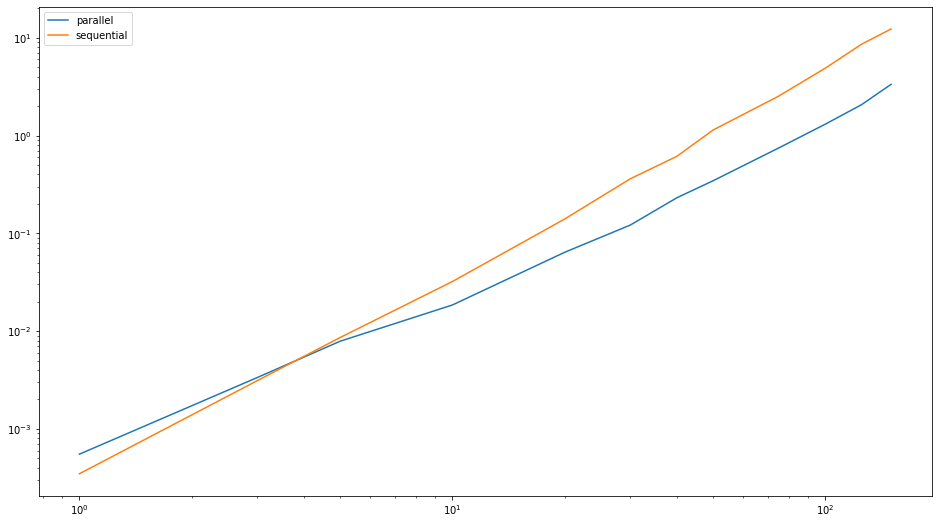

In [50]:
import pandas as pd

df = pd.DataFrame({'parallel': pcurve, 'sequential': scurve})
df.plot(loglog=True, figsize=(16, 9))